# Example: Extracellular current stimulation


In [1]:
%matplotlib inline
import sys
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron

In [9]:
# !nrnivmodl HallermannEtAl2012

### Fetch Hallermann et al. (2012) model files
We use this cell model, because it has a relatively sophisticated axon model, with myelinated and unmyelinated parts.

In [3]:
hallermann_folder = join("HallermannEtAl2012")

def return_hallermann_cell(tstop, dt, ):

    neuron.load_mechanisms(hallermann_folder)

    # Define cell parameters
    cell_parameters = {  # various cell parameters,
        'morphology': join(hallermann_folder, '28_04_10_num19.hoc'),
        'v_init': -80.,  # initial membrane potential
        'passive': False,  # do not add default passive mechs
        'nsegs_method': 'lambda_f',
        'lambda_f': 100.,
        'dt': dt,  # [ms] dt's should be in powers of 2 for both,
        'tstart': -100,  # start time of simulation, recorders start at t=0
        'tstop': tstop,
        "extracellular": True,
        "pt3d": True,
        'custom_code': [join(hallermann_folder, 'Cell parameters_mod.hoc')]
    }

    cell = LFPy.Cell(**cell_parameters)
    cell.set_rotation(x=np.pi / 2, y=-0.1, z=0)
    return cell


In [4]:
tstop = 30
dt = 2**-5

# delete old sections from NEURON namespace
neuron.h("forall delete_section()")

# cell = return_hallermann_cell(tstop, dt, )

1

### Function to calculate external potential from point current source

In [5]:
def make_extracellular_stimuli(dbs_params, cell):
    """ Function to calculate and apply external potential """
    x0, y0, z0 = dbs_params['position']
    sigma = 0.3
    ext_field = np.vectorize(lambda x,y,z: 1 / (4 * np.pi* sigma * np.sqrt(
        (x0 - x)**2 + (y0 - y)**2 + (z0 - z)**2)))
    
    ### MAKING THE EXTERNAL FIELD
    n_tsteps = int(cell.tstop / cell.dt + 1)
    t = np.arange(n_tsteps) * cell.dt
    pulse = np.zeros(n_tsteps)
    start_time = dbs_params['start_time']
    end_time = dbs_params['end_time']
    start_idx = np.argmin(np.abs(t - start_time))
    end_idx = np.argmin(np.abs(t - end_time))
    pulse[start_idx:end_idx] = dbs_params['amp'] * 1000.

    v_cell_ext = np.zeros((cell.totnsegs, n_tsteps))
    v_cell_ext[:, :] = ext_field(cell.x.mean(axis=-1), cell.y.mean(axis=-1), cell.z.mean(axis=-1)
                                ).reshape(cell.totnsegs, 1) * pulse.reshape(1, n_tsteps)
    
    print()
    
    cell.insert_v_ext(v_cell_ext, t)
    return ext_field, pulse

### Defining plotting functions

In [6]:
def plot_cell_secs(cell, ax_m):
    """ 
    Plotting function to plot cell morphology with 
    different sections in different colors
    """
    plot_idxs = [cell.somaidx[0],
                 cell.get_closest_idx(z=700, section='apic'),
                 cell.get_closest_idx(z=-850, section="node"),
                 #cell.get_closest_idx(z=0, section="axon"),
                 cell.get_closest_idx(z=1000, section="axon")
                 ]
    idx_clr = {idx: ['cyan', 'olive', 'b', 'darkviolet'][num]
               for num, idx in enumerate(plot_idxs)}
    
    possible_names = ["Myelin", "axon", "Unmyelin", "Node", "node", "my",
                      "hilloc",
                      "hill", "apic", "dend", "soma"]

    # We want sensible section names for the labels
    sec_name_mapping = {
        'soma': 'soma',
        'axon': "unmyelinated axon",
        'dend': "basal dendrite",
        'apic': "apical dendrite",
        'node': "node of Rannvier",
        'my': 'myelinated axon',
        }
    sec_clrs = {"Myelin": 'olive',
            "dend": '0.4',
            "soma": 'k',
            'apic': '0.8',
            "axon": 'purple',
            "node": 'orange',
            "my": 'g',
            "Unmyelin": 'salmon',
            "Node": 'orange',
            "hilloc": 'lightblue',
            "hill": 'pink',}

    used_sec_clrs = []
    used_sec_names = []
    
    
    for idx in range(cell.totnsegs):
        sec_name = cell.get_idx_name(idx)[1]
        for name_ in possible_names:
            if name_ in sec_name:
                c = sec_clrs[name_]
                if not sec_name_mapping[name_] in used_sec_names:
                    used_sec_clrs.append(c)
                    used_sec_names.append(sec_name_mapping[name_])
        if idx == 0:
            # Plot soma as dot
            ax_m.plot(cell.x[idx].mean(), cell.z[idx].mean(), 'o',
                  c=c, clip_on=True, ms=12)            
        else:
            ax_m.plot(cell.x[idx], cell.z[idx], '-',
                  c=c, clip_on=True, lw=1)

    
    [ax_m.plot(cell.x[idx].mean(), cell.z[idx].mean(), 'o',
               c=idx_clr[idx], ms=6, zorder=5) for idx in plot_idxs]
    return plot_idxs, idx_clr, used_sec_names, used_sec_clrs



def plotting_function(dbs_params, cell, ext_field, pulse):
    """
    Plotting function to plot cell and membrane potential.
    """
    x0, y0, z0 = dbs_params['position']
    amp = dbs_params['amp'] * 1000.
    
    ### PLOTTING THE RESULTS

    # Plotting the morphology
    plt.close('all')
    fig = plt.figure(figsize=(16,9))
    fig.subplots_adjust(hspace=0.5, bottom=0.15)
    
    ax_m = fig.add_subplot(121, aspect=1, xlabel='x [µm]', ylabel='z [µm]', 
                xticks=[-400, 0, 400], ylim=[-900, 1250], xlim=[-550, 550] )
    ax1 = fig.add_subplot(222, title='membrane potential', xlabel='Time [ms]', xlim=[10, 30], 
                          ylabel='mV', ylim=[-110, 60])
    
    ax2 = plt.subplot(224, ylim=[-2*np.max(np.abs(pulse / 1000)), 
                                 2*np.max(np.abs(pulse / 1000))], 
                      ylabel='µA', title='injected current', xlabel='Time [ms]', xlim=[10, 30])    
    
    # Plotting the extracellular potential produced by external stimuli
    v_field_ext = np.zeros((50, 200))
    xf = np.linspace(np.min(cell.x[:, 1]), np.max(cell.x[:, 1]), 50)
    zf = np.linspace(np.min(cell.z[:, 1]), np.max(cell.z[:, 1]), 200)
    for xidx, x in enumerate(xf):
       for zidx, z in enumerate(zf):
           v_field_ext[xidx, zidx] = ext_field(x, 0, z) * amp

    img = ax_m.imshow(v_field_ext.T, extent=[np.min(cell.x[:, 1]), np.max(cell.x[:, 1]), 
                                     np.min(cell.z[:, 1]), np.max(cell.z[:, 1])], 
              origin='lower', interpolation='nearest', cmap=plt.cm.bwr_r, vmin=-50, vmax=50)
    plt.colorbar(img, ax=ax_m, label='mV')
    
    cell_plot_idxs, cell_plot_colors, used_sec_names, used_sec_clrs = plot_cell_secs(cell, ax_m)   

    l, = ax_m.plot(x0, z0, 'y*', ms=12)

    # Add morphology legend markers
    lines = [l]
    line_names = ["current stimuli"]    
    for sec_name, sec_clr in zip(used_sec_names, used_sec_clrs):
        l_, = ax_m.plot([], [], c=sec_clr)
        lines.append(l_)
        line_names.append(sec_name)
    fig.legend(lines, line_names, frameon=False, ncol=3, loc=(0.1, 0.02))

    # Plotting the membrane potentials
    lines = []
    line_names = []
    for idx in cell_plot_idxs:
        l, = ax1.plot(cell.tvec, cell.vmem[idx, :], c=cell_plot_colors[idx], lw=2)
        lines.append(l)
        comp_loc = int(cell.x[idx].mean()), int(cell.y[idx].mean()), int(cell.z[idx].mean())
        line_names.append(f'{comp_loc} µm')
    ax1.legend(lines, line_names, frameon=False, loc="upper right")
    
    # Plotting the input currents
    ax2.plot(cell.tvec, pulse / 1000, c='k')


In [8]:
tstop = 30
dt = 2**-5

# delete old sections from NEURON namespace
# neuron.h("forall delete_section()")

cell = return_hallermann_cell(tstop, dt, )

# The parameters of the extracellular point current source 
dbs_params = {'position': [50, 0,  1050],  # x, y, z in µm
              'amp': -130., # µA,
              'start_time': 13.,  # ms
              'end_time': 15.,  # ms
              }

ext_field, pulse = make_extracellular_stimuli(dbs_params, cell)

cell.simulate(rec_vmem=True)

plotting_function(dbs_params, cell, ext_field, pulse)

NEURON mechanisms not found in HallermannEtAl2012.
	2079.3163 
	0 



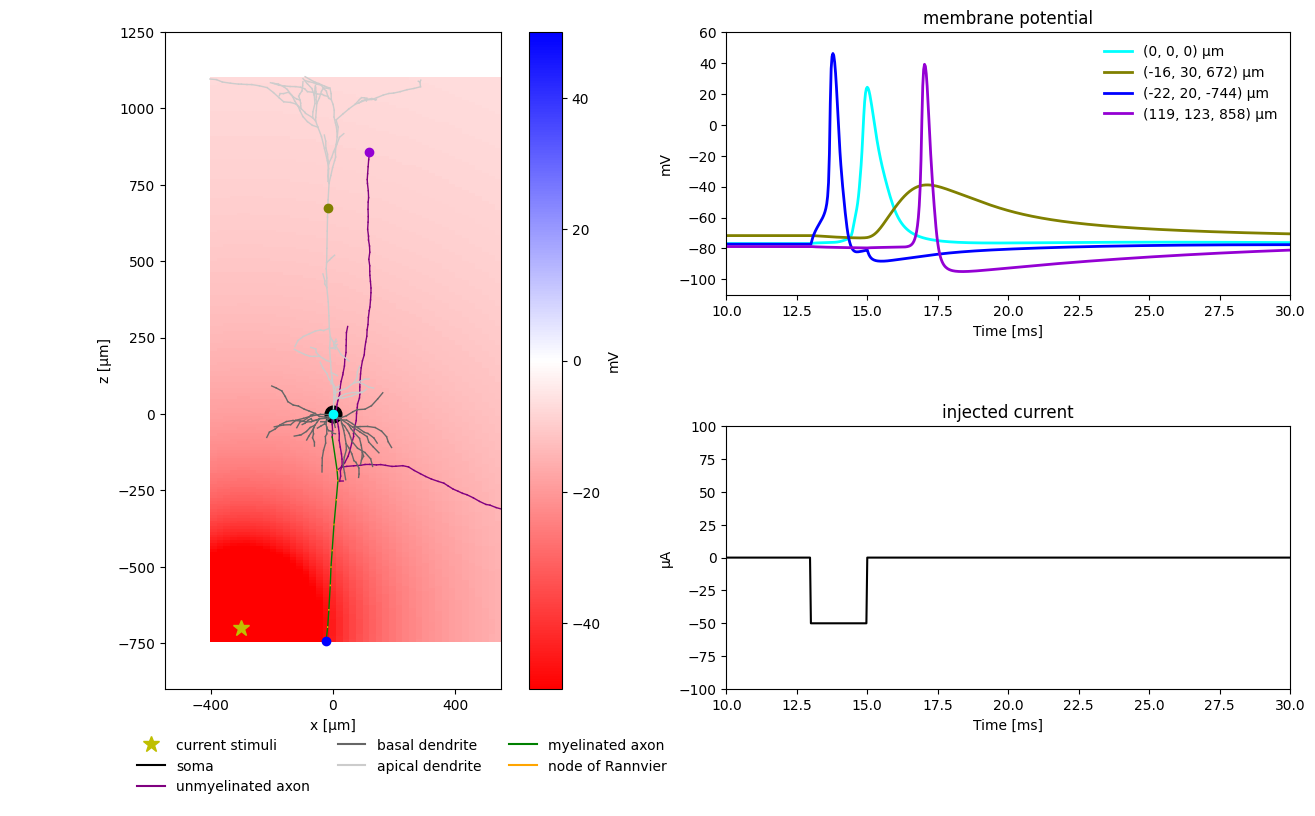

In [ ]:
tstop = 30
dt = 2**-5

# delete old sections from NEURON namespace
# neuron.h("forall delete_section()")

cell = return_hallermann_cell(tstop, dt, )

# The parameters of the extracellular point current source 
dbs_params = {'position': [-300, 0,  -700],  # x, y, z in µm
              'amp': -50., # µA,
              'start_time': 13.,  # ms
              'end_time': 15.,  # ms
              }

ext_field, pulse = make_extracellular_stimuli(dbs_params, cell)

cell.simulate(rec_vmem=True)

plotting_function(dbs_params, cell, ext_field, pulse)